In [ ]:
# this Notebook contains all the code for my final project for APLN_552, Special Topics in Natural Lagnauge Processing
# All of the files that are necessary to replicate this project come from the OneStopEnglish corpus,
# which may be downloaded here: https://github.com/nishkalavallabhi/OneStopEnglishCorpus
# Further information in the README file

In [1]:
import re
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import spacy
import textstat


C:\Users\mande\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Define Functions

In [2]:
def strip_process_file(file):

# this is a very "intro-to-python" function
# takes a txt file as argument
# returns a string
    
    txt_test = ""
    input_fd = open(file, "r", errors='ignore')
    for line_str in input_fd:
#         line_str = line_str.decode('utf-8',errors='ignore')
        line_str = line_str.strip() # remove the carriage return
        txt_test += " "
        txt_test += line_str

    input_fd.close()
    return txt_test


In [3]:
# Splits the text into sentences, using 
# Spacy's sentence segmentation which can 
# be found at https://spacy.io/usage/spacy-101

def break_sentences(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    return list(doc.sents)
 
# Returns Number of Words in the text
# I have not looked "under the hood" at the follwing function.
# It seems to be overcounting the words in a text by about 10~15%
# So I did not use it for the word count feature
# However, I left it in for the calculations of average sentence length and FKRE
# Since those tools rely on it

def word_count(text):
    sentences = break_sentences(text)
    words = 0
    for sentence in sentences:
        words += len([token for token in sentence])
    return words
 
# Returns the number of sentences in the text
def sentence_count(text):
    sentences = break_sentences(text)
    return len(sentences)
 
# Returns average sentence length
def avg_sentence_length(text):
    words = word_count(text)
    sentences = sentence_count(text)
    average_sentence_length = float(words / sentences)
    return average_sentence_length
 
# Return max sentence length
# I wrote this function looking for the longest sentence in a text
# I was getting a false positive in the results when I tested it out
# Leaving it in for now, possibly can use in later experiments

def max_sentence_length(text):
    sentences = break_sentences(text)
    max_length = 0
    for sentence in sentences:
        sent_length = 0
        sent_length += len([token for token in sentence])
        if sent_length > max_length:
            max_length = sent_length
    return max_length

In [4]:
def my_token_counter(text):
    # this is my simple "light switch" function for word count
    token_count = 0
    switch = False # start with the switch off
    for char in text: # Iterating through the characters in the string
        if char.isspace() == False: # When encountering a non-white-space character
            if switch == False:
                token_count += 1 # add one to the word count
            switch = True        # and turn on the switch
        else:                    # if the character is white-space
            switch = False       # turn the switch off
    return token_count


## Testing selected functions

In [16]:
# In this cell, I will compare the performance of the word counting functions:
# nltk, spacy, and my token counter

titles = ["Banksy-ele", "Banksy-int", "Banksy-adv", "gettysburg"] # four text files
gd_mwcl = [419, 593, 772, 271] # Google docs copy-paste word count
nltk_wcl = []
spacy_wcl = []
my_wcl = []

files = ["ose_1ele_txt/Banksy-ele.txt", "ose_2int_txt/Banksy-int.txt", "ose_3adv_txt/Banksy-adv.txt", "gettysburg.txt"]

for file in files:
    text_str = strip_process_file(file)
    nltk_tokens = nltk.word_tokenize(text_str)
    for token in nltk_tokens:
        if token.isalnum() == False:
            nltk_tokens.remove(token) # this removes punctuation tokens          
    nltk_token_count = len(nltk_tokens)
    nltk_wcl.append(nltk_token_count)
    spacy_word_count = word_count(text_str)
    spacy_wcl.append(spacy_word_count)
    my_token_count = my_token_counter(text_str)
    my_wcl.append(my_token_count)
    
data = {'Title': titles,
        'Google docs': gd_mwcl,
        'nltk': nltk_wcl,
        'spacy': spacy_wcl,
        'crude': my_wcl}

wc_df = pd.DataFrame(data)
wc_df['nltk_accuracy'] = 1 - abs(wc_df["nltk"]-wc_df["Google docs"]) / wc_df["Google docs"]
wc_df['spacy_accuracy'] = 1 - abs(wc_df["spacy"]-wc_df["Google docs"]) / wc_df["Google docs"]
wc_df['crude_accuracy'] = 1 - abs(wc_df["crude"]-wc_df["Google docs"]) / wc_df["Google docs"]
wc_df.describe()

,Google docs,nltk,spacy,crude,nltk_accuracy,spacy_accuracy,crude_accuracy
count,4.0000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,513.7500,506.500000,579.000000,514.500000,0.987123,0.869081,0.991506
std,216.7016,212.512745,240.644967,214.162711,0.006241,0.021762,0.011730
min,271.0000,270.000000,315.000000,278.000000,0.983137,0.837638,0.974170
25%,382.0000,376.500000,428.250000,382.250000,0.983254,0.865818,0.989962
50%,506.0000,497.500000,566.500000,504.000000,0.984522,0.875429,0.995927
75%,637.7500,627.500000,717.250000,636.250000,0.988391,0.878693,0.997470
max,772.0000,761.000000,868.000000,772.000000,0.996310,0.887828,1.000000


In [17]:
# syllable count function is part of flesch-kincaid reading ease calculation
# test run shows that it is not performing accurately
# however, it never seems to over-count syllables, only under-count,
# mostly when the words have suffixes or final vowels

from textstat.textstat import textstatistics
def syllables_count(word):
    return textstatistics().syllable_count(word)

words = ["crime", "criminal","Crimea", "cry", "crying", "rhyme", "rhyming", "rhythmic"]

true_syl_counts = [1, 3, 3, 1, 2, 1, 2, 2]
textstat_counts = []
eval_list = []

for word in words:
    textstat_counts.append(syllables_count(word))
    
for i in range(len(words)):
    if textstat_counts[i] == true_syl_counts[i]:
        eval_list.append("correct")
    else:
        eval_list.append("incorrect")
    print('{} has {} syllables - {}'.format(words[i],textstat_counts[i],eval_list[i]))

crime has 1 syllables - correct
criminal has 3 syllables - correct
Crimea has 1 syllables - incorrect
cry has 1 syllables - correct
crying has 2 syllables - correct
rhyme has 1 syllables - correct
rhyming has 1 syllables - incorrect
rhythmic has 2 syllables - correct


## Process texts and create dataframe

In [18]:
# plain text corpus has been downloaded into three subdirectories: ose_1ele_txt, ose_2int_txt, and ose_3adv_txt
# this function processes those three subdirectories
# and returns a dataframe with the following columns:
# text title
# text label (0 for ele, 1 for int, 2 for adv)
# token count from nltk
# type count from nltk
# type-token ratio from nltk
# crude homemade word count
# spacy word count
# spacy sentence count
# spacy average sentence length
# Flesch reading ease score

def process_dir(directory):
    
    text_titles = []
    text_labels = []
    text_levels = []
    nltk_token_counts = []
    nltk_type_counts = []
    ttr_list = []
    
    my_token_counts = []
    
    spacy_word_counts = []
    sentence_counts = []
    avg_sentence_lengths = []
    fre_list = []
    
#     stopwords_english = stopwords.words('english')
    
    path = directory + "/"
    file_list = os.listdir(directory)

    for title in file_list:
        file = path + title
        raw_text = strip_process_file(file) # do i even need to do that?
        
        # nltk feature extraction
        
        raw_tokens = nltk.word_tokenize(raw_text) # looks like this automatically removes stopwords already
        for token in raw_tokens:
            if token.isalnum() == False:
                raw_tokens.remove(token) # this removes punctuation tokens          
#             if token in stopwords_english == True: 
#                 raw_tokens.remove(token) # get the stopwords out
        nltk_token_count = len(raw_tokens)
        nltk_type_set = set(raw_tokens)
        nltk_type_count = len(nltk_type_set)
        nltk_ttr = round(nltk_type_count / nltk_token_count, 3)
        
        # my feature extraction
        
        my_token_count = my_token_counter(raw_text)
        
        # spacy and textstat feature extraction
        
        spacy_word_count = word_count(raw_text)
        spacy_sent_count = sentence_count(raw_text)
        spacy_avg_sen_len = avg_sentence_length(raw_text)
        fre = textstat.flesch_reading_ease(raw_text)

        # start adding things to the lists so I can zip them into the df

        text_titles.append(title[:-4]) # remove '.txt' from the title
        label = title[-7:-4]           # convert the ele int adv tags to numerical labels
        text_labels.append(label)
        if label == 'ele':
            level = 0
        elif label == 'int':
            level = 1
        elif label == 'adv':
            level = 2
        text_levels.append(level)
        nltk_token_counts.append(nltk_token_count)
        nltk_type_counts.append(nltk_type_count)
        ttr_list.append(nltk_ttr)
        
        my_token_counts.append(my_token_count)
        
        spacy_word_counts.append(spacy_word_count)
        sentence_counts.append(spacy_sent_count)
        avg_sentence_lengths.append(spacy_avg_sen_len)
        fre_list.append(fre)

    data = {'Title': text_titles,
            'Label': text_labels,
            'Level': text_levels,
            'nltk Tokens': nltk_token_counts,
            'nltk Types': nltk_type_counts,
            'TTR': ttr_list,
            'my tokens': my_token_counts,
            'spacy wc': spacy_word_counts,
            'spacy sc': sentence_counts,
            'avg sent len': avg_sentence_lengths,
            'Flesch RE': fre_list}

    # Create DataFrame
    df = pd.DataFrame(data)

    return df

In [19]:
df_all = process_dir('ose_all_txt')

In [20]:
# df_all.groupby(['Level']).describe()

df_ele = df_all[df_all.Level == 0]
df_int = df_all[df_all.Level == 1]
df_adv = df_all[df_all.Level == 2]

df_ele_int = df_all[df_all.Level != 2]
df_int_adv = df_all[df_all.Level != 0]
df_ele_adv = df_all[df_all.Level != 1]

df_ele.head()
df_int.head()
df_adv.head()

,Title,Label,Level,nltk Tokens,nltk Types,TTR,my tokens,spacy wc,spacy sc,avg sent len,Flesch RE
0,Amazon-adv,adv,2,610,320,0.525,625,732,22,33.272727,51.68
3,Amsterdam-adv,adv,2,440,241,0.548,452,503,17,29.588235,55.78
6,Anita-adv,adv,2,915,465,0.508,940,1109,45,24.644444,60.14
9,Arctic mapping-adv,adv,2,773,429,0.555,793,911,26,35.038462,58.55
12,Banksy-adv,adv,2,761,353,0.464,772,868,26,33.384615,61.40


## Create arrays, Sepaprate Training and Test sets, Classify, and Evaluate

In [21]:
# Create numpy arrays of word count, ttr, avg sentence length, and Flesch Reading Ease for each set of texts

ele_array = df_ele[["my tokens", "TTR", "avg sent len", "Flesch RE"]].to_numpy()
ele_labels = df_ele[["Level"]].to_numpy()

int_array = df_int[["my tokens", "TTR", "avg sent len", "Flesch RE"]].to_numpy()
int_labels = df_int[["Level"]].to_numpy()

adv_array = df_adv[["my tokens", "TTR", "avg sent len", "Flesch RE"]].to_numpy()
adv_labels = df_adv[["Level"]].to_numpy()

# Assign texts to training and test sets

trial_1_test_ele = ele_array[:94]
trial_1_train_ele = ele_array[94:]
trial_1_test_int = int_array[:94]
trial_1_train_int = int_array[94:]
trial_1_test_adv = adv_array[:94]
trial_1_train_adv = adv_array[94:]

trial_2_test_ele = ele_array[94:]
trial_2_train_ele = ele_array[:94]
trial_2_test_int = int_array[94:]
trial_2_train_int = int_array[:94]
trial_2_test_adv = adv_array[94:]
trial_2_train_adv = adv_array[:94]

In [22]:
def evaluate(test_x, test_y):

    from sklearn import metrics
    predictions = clf.predict(test_x)
    accuracy_score = metrics.accuracy_score(predictions, test_y)
    precision_score = metrics.precision_score(predictions, test_y)
    recall_score = metrics.recall_score(predictions, test_y)

    return precision_score, recall_score, accuracy_score


In [23]:
# Trial 1 - beginner vs intermediate

train_x = np.concatenate((trial_1_train_ele, trial_1_train_int)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_int))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_int),1)), axis=0)

# print("train_x.shape = " + str(train_x.shape))
# print("train_y.shape = " + str(train_y.shape))

In [24]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [25]:
ele_v_int_trial_1_precision, ele_v_int_trial_1_recall, ele_v_int_trial_1_accuracy = evaluate(test_x, test_y)

In [26]:
# Trial 2 - beginner vs. intermediate

train_x = np.concatenate((trial_2_train_ele, trial_2_train_int)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_int))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_int),1)), axis=0)

# print("train_x.shape = " + str(train_x.shape))
# print("train_y.shape = " + str(train_y.shape))

In [27]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [28]:
ele_v_int_trial_2_precision, ele_v_int_trial_2_recall, ele_v_int_trial_2_accuracy = evaluate(test_x, test_y)

In [29]:
# Trial 1 - intermediate v advanced

train_x = np.concatenate((trial_1_train_int, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_int, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_int),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_int),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

# print("train_x.shape = " + str(train_x.shape))
# print("train_y.shape = " + str(train_y.shape))

In [30]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [31]:
int_v_adv_trial_1_precision, int_v_adv_trial_1_recall, int_v_adv_trial_1_accuracy = evaluate(test_x, test_y)

In [32]:
# Trial 2 - intermediate v advanced

train_x = np.concatenate((trial_2_train_int, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_int, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_int),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_int),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

# print("train_x.shape = " + str(train_x.shape))
# print("train_y.shape = " + str(train_y.shape))

In [33]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [34]:
int_v_adv_trial_2_precision, int_v_adv_trial_2_recall, int_v_adv_trial_2_accuracy = evaluate(test_x, test_y)

In [35]:
# Trial 1 - elementary v advanced

train_x = np.concatenate((trial_1_train_ele, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

In [36]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [37]:
ele_v_adv_trial_1_precision, ele_v_adv_trial_1_recall, ele_v_adv_trial_1_accuracy = evaluate(test_x, test_y)

In [38]:
# Trial 2 - elementary v advanced

train_x = np.concatenate((trial_2_train_ele, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

In [39]:
from sklearn import svm
X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [40]:
ele_v_adv_trial_2_precision, ele_v_adv_trial_2_recall, ele_v_adv_trial_2_accuracy = evaluate(test_x, test_y)

In [41]:
print("ele_v_int trial 1 accuracy:",ele_v_int_trial_1_accuracy)
print("ele_v_int trial 1 precision:",ele_v_int_trial_1_precision)
print("ele_v_int trial 1 recall:",ele_v_int_trial_1_recall)
print("ele_v_int trial 2 accuracy:",ele_v_int_trial_2_accuracy)
print("ele_v_int trial 2 precision:",ele_v_int_trial_2_precision)
print("ele_v_int trial 2 recall:",ele_v_int_trial_2_recall)
print("int_v_adv trial 1 accuracy:",int_v_adv_trial_1_accuracy)
print("int_v_adv trial 1 precision:",int_v_adv_trial_1_precision)
print("int_v_adv trial 1 recall:",int_v_adv_trial_1_recall)
print("int_v_adv trial 2 accuracy:",int_v_adv_trial_2_accuracy)
print("int_v_adv trial 2 precision:",int_v_adv_trial_2_precision)
print("int_v_adv trial 2 recall:",int_v_adv_trial_2_recall)
print("ele_v_adv trial 1 accuracy:",ele_v_adv_trial_1_accuracy)
print("ele_v_adv trial 1 precision:",ele_v_adv_trial_1_precision)
print("ele_v_adv trial 1 recall:",ele_v_adv_trial_1_recall)
print("ele_v_adv trial 2 accuracy:",ele_v_adv_trial_2_accuracy)
print("ele_v_adv trial 2 precision:",ele_v_adv_trial_2_precision)
print("ele_v_adv trial 2 recall:",ele_v_adv_trial_2_recall)



ele_v_int trial 1 accuracy: 0.7393617021276596
ele_v_int trial 1 precision: 0.6063829787234043
ele_v_int trial 1 recall: 0.8260869565217391
ele_v_int trial 2 accuracy: 0.7526315789473684
ele_v_int trial 2 precision: 0.7789473684210526
ele_v_int trial 2 recall: 0.74
int_v_adv trial 1 accuracy: 0.723404255319149
int_v_adv trial 1 precision: 0.4787234042553192
int_v_adv trial 1 recall: 0.9375
int_v_adv trial 2 accuracy: 0.7052631578947368
int_v_adv trial 2 precision: 0.6
int_v_adv trial 2 recall: 0.76
ele_v_adv trial 1 accuracy: 0.8776595744680851
ele_v_adv trial 1 precision: 0.7872340425531915
ele_v_adv trial 1 recall: 0.961038961038961
ele_v_adv trial 2 accuracy: 0.8736842105263158
ele_v_adv trial 2 precision: 0.8210526315789474
ele_v_adv trial 2 recall: 0.9176470588235294


## Graphing Results of Classifier, Trials 1 and 2 (4 features)

In [42]:
from matplotlib import pyplot as plt

def plot_apr(array, title):
    x = "Accuracy", "Precision", "Recall", "Accuracy", "Precision", "Recall"
    y = array[0], array[1], array[2], array[3], array[4], array[5]
    plt.bar(x,y)
    plt.title(title)
    plt.show()    

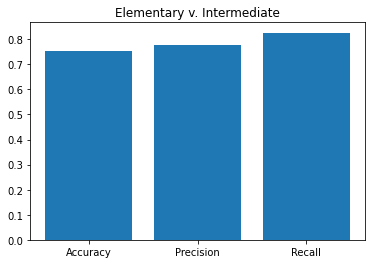

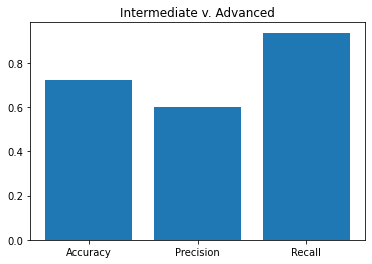

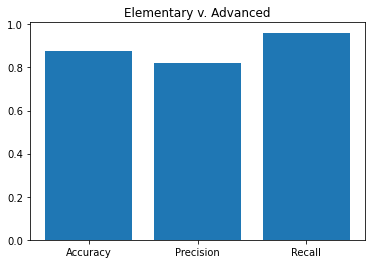

In [43]:
ele_v_int_array = [ele_v_int_trial_1_accuracy, ele_v_int_trial_1_precision, ele_v_int_trial_1_recall,
                   ele_v_int_trial_2_accuracy, ele_v_int_trial_2_precision, ele_v_int_trial_2_recall]
int_v_adv_array = [int_v_adv_trial_1_accuracy, int_v_adv_trial_1_precision, int_v_adv_trial_1_recall,
                   int_v_adv_trial_2_accuracy, int_v_adv_trial_2_precision, int_v_adv_trial_2_recall]
ele_v_adv_array = [ele_v_adv_trial_1_accuracy, ele_v_adv_trial_1_precision, ele_v_adv_trial_1_recall,
                   ele_v_adv_trial_2_accuracy, ele_v_adv_trial_2_precision, ele_v_adv_trial_2_recall]

plot_apr(ele_v_int_array, "Elementary v. Intermediate")
plot_apr(int_v_adv_array, "Intermediate v. Advanced")
plot_apr(ele_v_adv_array, "Elementary v. Advanced")

## Classifier Trials 3 and 4 - word count and sentence length only

In [44]:
# feature engineering
# try repeating the tests with fewer features
# word count and avg sent len only

ele_array = df_ele[["my tokens", "avg sent len"]].to_numpy()
ele_labels = df_ele[["Level"]].to_numpy()

int_array = df_int[["my tokens", "avg sent len"]].to_numpy()
int_labels = df_int[["Level"]].to_numpy()

adv_array = df_adv[["my tokens", "avg sent len"]].to_numpy()
adv_labels = df_adv[["Level"]].to_numpy()

# Assign texts to training and test sets

trial_1_test_ele = ele_array[:94]
trial_1_train_ele = ele_array[94:]
trial_1_test_int = int_array[:94]
trial_1_train_int = int_array[94:]
trial_1_test_adv = adv_array[:94]
trial_1_train_adv = adv_array[94:]

trial_2_test_ele = ele_array[94:]
trial_2_train_ele = ele_array[:94]
trial_2_test_int = int_array[94:]
trial_2_train_int = int_array[:94]
trial_2_test_adv = adv_array[94:]
trial_2_train_adv = adv_array[:94]

In [45]:
# Trial 3 - beginner vs intermediate with only two features
# word count and avg sent len only

train_x = np.concatenate((trial_1_train_ele, trial_1_train_int)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_int))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_int),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_int_trial_3_precision, ele_v_int_trial_3_recall, ele_v_int_trial_3_accuracy = evaluate(test_x, test_y)

# Trial 4 - beginner vs. intermediate with only two features
# word count and avg sent len only


train_x = np.concatenate((trial_2_train_ele, trial_2_train_int)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_int))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_int),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_int_trial_4_precision, ele_v_int_trial_4_recall, ele_v_int_trial_4_accuracy = evaluate(test_x, test_y)


# Trial 3 - intermediate v advanced with only two features
# word count and avg sent len only


train_x = np.concatenate((trial_1_train_int, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_int, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_int),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_int),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

int_v_adv_trial_3_precision, int_v_adv_trial_3_recall, int_v_adv_trial_3_accuracy = evaluate(test_x, test_y)

# Trial 4 - intermediate v advanced with only two features
# word count and avg sent len only


train_x = np.concatenate((trial_2_train_int, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_int, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_int),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_int),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

int_v_adv_trial_4_precision, int_v_adv_trial_4_recall, int_v_adv_trial_4_accuracy = evaluate(test_x, test_y)

# Trial 3 - elementary v advanced with only two features
# word count and avg sent len only


train_x = np.concatenate((trial_1_train_ele, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_adv_trial_3_precision, ele_v_adv_trial_3_recall, ele_v_adv_trial_3_accuracy = evaluate(test_x, test_y)

# Trial 4 - elementary v advanced with only two features
# word count and avg sent len only


train_x = np.concatenate((trial_2_train_ele, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_adv_trial_4_precision, ele_v_adv_trial_4_recall, ele_v_adv_trial_4_accuracy = evaluate(test_x, test_y)

print("ele_v_int trial 3 accuracy:",ele_v_int_trial_3_accuracy)
print("ele_v_int trial 3 precision:",ele_v_int_trial_3_precision)
print("ele_v_int trial 3 recall:",ele_v_int_trial_3_recall)
print("ele_v_int trial 4 accuracy:",ele_v_int_trial_4_accuracy)
print("ele_v_int trial 4 precision:",ele_v_int_trial_4_precision)
print("ele_v_int trial 4 recall:",ele_v_int_trial_4_recall)
print("int_v_adv trial 3 accuracy:",int_v_adv_trial_3_accuracy)
print("int_v_adv trial 3 precision:",int_v_adv_trial_3_precision)
print("int_v_adv trial 3 recall:",int_v_adv_trial_3_recall)
print("int_v_adv trial 4 accuracy:",int_v_adv_trial_4_accuracy)
print("int_v_adv trial 4 precision:",int_v_adv_trial_4_precision)
print("int_v_adv trial 4 recall:",int_v_adv_trial_4_recall)
print("ele_v_adv trial 3 accuracy:",ele_v_adv_trial_3_accuracy)
print("ele_v_adv trial 3 precision:",ele_v_adv_trial_3_precision)
print("ele_v_adv trial 3 recall:",ele_v_adv_trial_3_recall)
print("ele_v_adv trial 4 accuracy:",ele_v_adv_trial_4_accuracy)
print("ele_v_adv trial 4 precision:",ele_v_adv_trial_4_precision)
print("ele_v_adv trial 4 recall:",ele_v_adv_trial_4_recall)

ele_v_int trial 3 accuracy: 0.7340425531914894
ele_v_int trial 3 precision: 0.6063829787234043
ele_v_int trial 3 recall: 0.8142857142857143
ele_v_int trial 4 accuracy: 0.7526315789473684
ele_v_int trial 4 precision: 0.7789473684210526
ele_v_int trial 4 recall: 0.74
int_v_adv trial 3 accuracy: 0.723404255319149
int_v_adv trial 3 precision: 0.4787234042553192
int_v_adv trial 3 recall: 0.9375
int_v_adv trial 4 accuracy: 0.7052631578947368
int_v_adv trial 4 precision: 0.5789473684210527
int_v_adv trial 4 recall: 0.7746478873239436
ele_v_adv trial 3 accuracy: 0.8776595744680851
ele_v_adv trial 3 precision: 0.7872340425531915
ele_v_adv trial 3 recall: 0.961038961038961
ele_v_adv trial 4 accuracy: 0.8736842105263158
ele_v_adv trial 4 precision: 0.8210526315789474
ele_v_adv trial 4 recall: 0.9176470588235294


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [49]:
# feature engineering
# try repeating the tests with fewer features
# word count only

ele_array = df_ele[["my tokens"]].to_numpy()
ele_labels = df_ele[["Level"]].to_numpy()

int_array = df_int[["my tokens"]].to_numpy()
int_labels = df_int[["Level"]].to_numpy()

adv_array = df_adv[["my tokens"]].to_numpy()
adv_labels = df_adv[["Level"]].to_numpy()

# Assign texts to training and test sets

trial_1_test_ele = ele_array[:94]
trial_1_train_ele = ele_array[94:]
trial_1_test_int = int_array[:94]
trial_1_train_int = int_array[94:]
trial_1_test_adv = adv_array[:94]
trial_1_train_adv = adv_array[94:]

trial_2_test_ele = ele_array[94:]
trial_2_train_ele = ele_array[:94]
trial_2_test_int = int_array[94:]
trial_2_train_int = int_array[:94]
trial_2_test_adv = adv_array[94:]
trial_2_train_adv = adv_array[:94]

In [50]:
# Trial 5 - elementary vs intermediate
# word count only

train_x = np.concatenate((trial_1_train_ele, trial_1_train_int)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_int))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_int),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_int_trial_5_precision, ele_v_int_trial_5_recall, ele_v_int_trial_5_accuracy = evaluate(test_x, test_y)

# Trial 6 - elementary vs. intermediate
# word count only


train_x = np.concatenate((trial_2_train_ele, trial_2_train_int)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_int))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_int),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_int),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_int_trial_6_precision, ele_v_int_trial_6_recall, ele_v_int_trial_6_accuracy = evaluate(test_x, test_y)


# Trial 5 - intermediate v advanced
# word count only


train_x = np.concatenate((trial_1_train_int, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_int, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_int),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_int),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

int_v_adv_trial_5_precision, int_v_adv_trial_5_recall, int_v_adv_trial_5_accuracy = evaluate(test_x, test_y)

# Trial 6 - intermediate v advanced
# word count only


train_x = np.concatenate((trial_2_train_int, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_int, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_int),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_int),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

int_v_adv_trial_6_precision, int_v_adv_trial_6_recall, int_v_adv_trial_6_accuracy = evaluate(test_x, test_y)

# Trial 5 - elementary v advanced
# word count only


train_x = np.concatenate((trial_1_train_ele, trial_1_train_adv)) 
test_x = np.concatenate((trial_1_test_ele, trial_1_test_adv))

train_y = np.append(np.zeros((len(trial_1_train_ele),1)), np.ones((len(trial_1_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_1_test_ele),1)), np.ones((len(trial_1_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_adv_trial_5_precision, ele_v_adv_trial_5_recall, ele_v_adv_trial_5_accuracy = evaluate(test_x, test_y)

# Trial 6 - elementary v advanced
# word count only


train_x = np.concatenate((trial_2_train_ele, trial_2_train_adv)) 
test_x = np.concatenate((trial_2_test_ele, trial_2_test_adv))

train_y = np.append(np.zeros((len(trial_2_train_ele),1)), np.ones((len(trial_2_train_adv),1)), axis=0)
test_y = np.append(np.zeros((len(trial_2_test_ele),1)), np.ones((len(trial_2_test_adv),1)), axis=0)

X = train_x
y = train_y
clf = svm.SVC()
clf.fit(X, y)

ele_v_adv_trial_6_precision, ele_v_adv_trial_6_recall, ele_v_adv_trial_6_accuracy = evaluate(test_x, test_y)

print("ele_v_int trial 5 accuracy:",ele_v_int_trial_5_accuracy)
print("ele_v_int trial 5 precision:",ele_v_int_trial_5_precision)
print("ele_v_int trial 5 recall:",ele_v_int_trial_5_recall)
print("ele_v_int trial 6 accuracy:",ele_v_int_trial_6_accuracy)
print("ele_v_int trial 6 precision:",ele_v_int_trial_6_precision)
print("ele_v_int trial 6 recall:",ele_v_int_trial_6_recall)
print("int_v_adv trial 5 accuracy:",int_v_adv_trial_5_accuracy)
print("int_v_adv trial 5 precision:",int_v_adv_trial_5_precision)
print("int_v_adv trial 5 recall:",int_v_adv_trial_5_recall)
print("int_v_adv trial 6 accuracy:",int_v_adv_trial_6_accuracy)
print("int_v_adv trial 6 precision:",int_v_adv_trial_6_precision)
print("int_v_adv trial 6 recall:",int_v_adv_trial_6_recall)
print("ele_v_adv trial 5 accuracy:",ele_v_adv_trial_5_accuracy)
print("ele_v_adv trial 5 precision:",ele_v_adv_trial_5_precision)
print("ele_v_adv trial 5 recall:",ele_v_adv_trial_5_recall)
print("ele_v_adv trial 6 accuracy:",ele_v_adv_trial_6_accuracy)
print("ele_v_adv trial 6 precision:",ele_v_adv_trial_6_precision)
print("ele_v_adv trial 6 recall:",ele_v_adv_trial_6_recall)

ele_v_int trial 5 accuracy: 0.723404255319149
ele_v_int trial 5 precision: 0.5425531914893617
ele_v_int trial 5 recall: 0.85
ele_v_int trial 6 accuracy: 0.7526315789473684
ele_v_int trial 6 precision: 0.7684210526315789
ele_v_int trial 6 recall: 0.7448979591836735
int_v_adv trial 5 accuracy: 0.7180851063829787
int_v_adv trial 5 precision: 0.46808510638297873
int_v_adv trial 5 recall: 0.9361702127659575
int_v_adv trial 6 accuracy: 0.7052631578947368
int_v_adv trial 6 precision: 0.5473684210526316
int_v_adv trial 6 recall: 0.8
ele_v_adv trial 5 accuracy: 0.8776595744680851
ele_v_adv trial 5 precision: 0.7872340425531915
ele_v_adv trial 5 recall: 0.961038961038961
ele_v_adv trial 6 accuracy: 0.8736842105263158
ele_v_adv trial 6 precision: 0.8210526315789474
ele_v_adv trial 6 recall: 0.9176470588235294


C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mande\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [46]:
# pseudo code for what I want to do with the vocab extractor
# read the csv
# build a set of the words in sentence 1, elementary
# add the words of sentence 1, intermediate
# build a set of the words in sentence 1, advanced
# subtract (ele+int) from adv

# test_df = pd.read_csv('ose_csv/Amazon.csv', encoding_errors='ignore')

# test_df.head()